In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from torch.utils.data.sampler import WeightedRandomSampler

In [2]:
def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []
    
    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)

    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]

    real_videos = real_videos[:2000]
    fake_videos = fake_videos[:2000]
    
    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")

    splits_dict = {split: [] for split in ['train', 'val', 'test']}
    
    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)
        
        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)
    
    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)
    
    return splits_dict, class_counts

In [3]:
class VideoDatasetSplit(Dataset):
    def __init__(self, base_path, split_path, split='train', sequence_length=15, transform=None):
        self.base_path = Path(base_path)
        self.sequence_length = sequence_length
        self.transform = transform
        
        with open(os.path.join(split_path, 'splits.json'), 'r') as f:
            data = json.load(f)
            self.videos = data['splits'][split]
            self.class_counts = data['class_counts']
    
    def get_sampler(self):
        weights = []
        max_samples = max(self.class_counts.values())
        
        for video_path in self.videos:
            is_fake = 'synthesis' in video_path
            count = self.class_counts['fake'] if is_fake else self.class_counts['real']
            weight = max_samples / count
            weights.append(weight)
        
        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))
    
    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = 1 if 'synthesis' in video_path else 0  # 1 for fake, 0 for real
        
        frames = self.load_video(os.path.join(self.base_path, video_path))
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        
        return frames, label
    
    def __len__(self):
        return len(self.videos)
    
    def load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frames-1, self.sequence_length, dtype=int)
        
        for frame_idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                frames.append(np.zeros(frames[-1].shape, dtype=np.uint8))
        
        cap.release()
        return np.stack(frames)

def create_dataloaders(base_path, output_path,dim, batch_size=4, sequence_length=10):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    splits_dict, class_counts = create_dataset_splits(base_path, output_path)
    
    train_dataset = VideoDatasetSplit(base_path, output_path, 'train', sequence_length, transform)
    val_dataset = VideoDatasetSplit(base_path, output_path, 'val', sequence_length, transform)
    test_dataset = VideoDatasetSplit(base_path, output_path, 'test', sequence_length, transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        sampler=train_dataset.get_sampler(),
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, class_counts

In [4]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders('/kaggle/input/celeb-df-v2','/kaggle/working/',dim=224,batch_size=12,sequence_length=16)

Real videos: 890, Fake videos: 2000


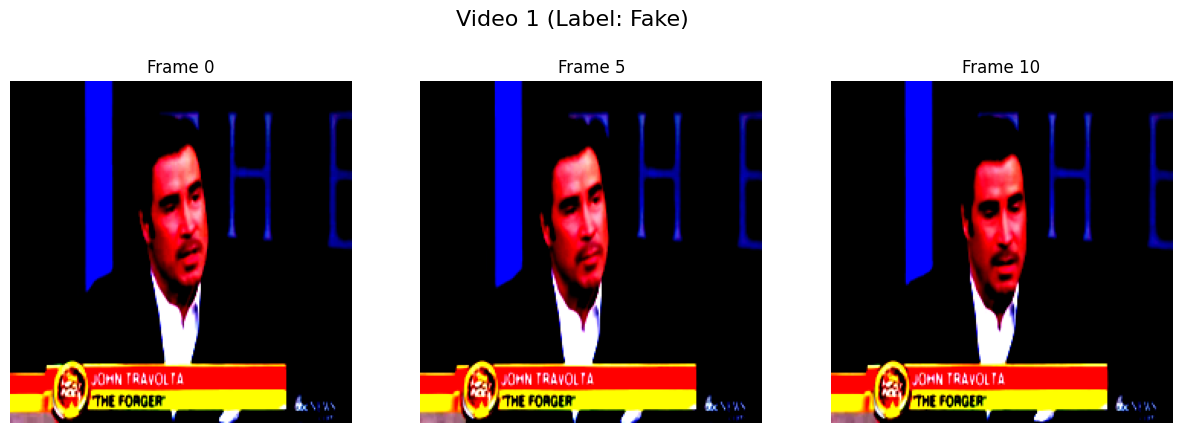

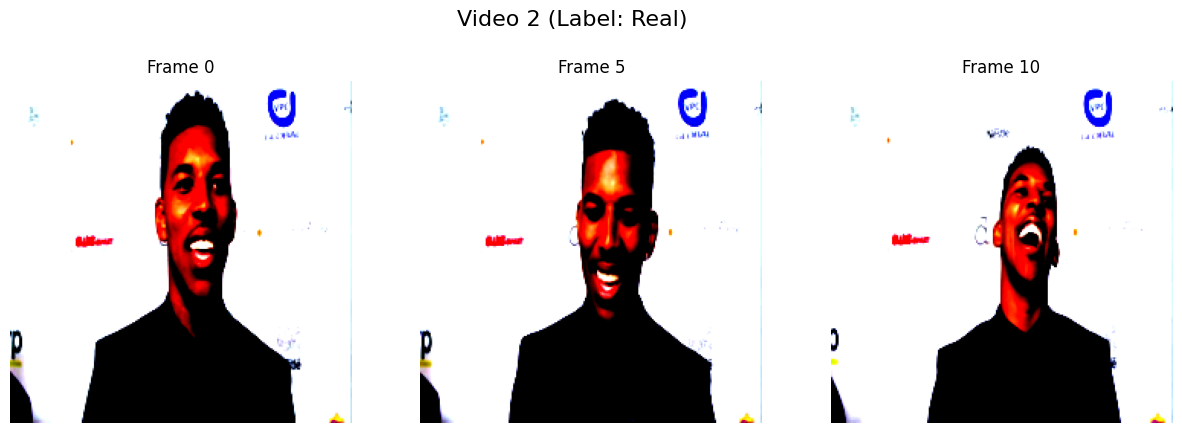

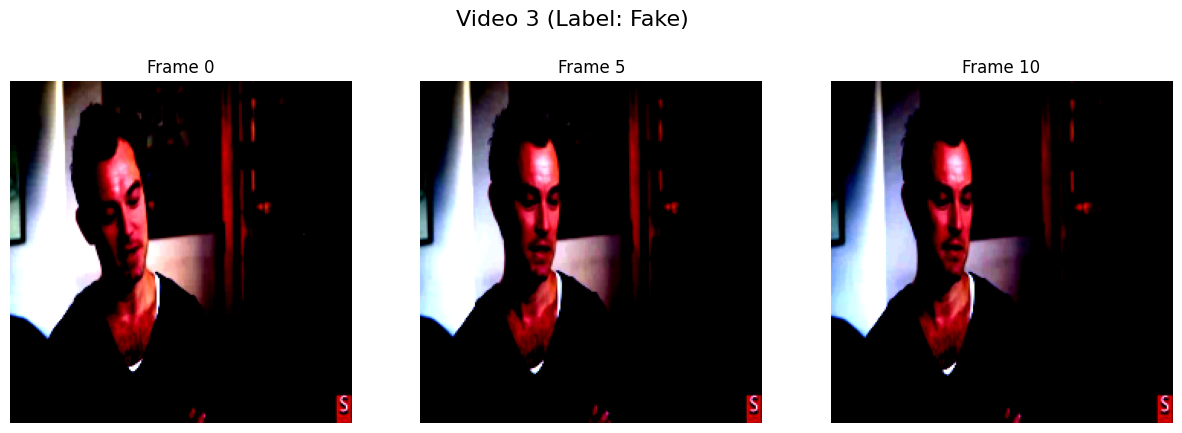

In [5]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=5, num_frames=5):
    """
    Visualizes frames from videos in a batch.
    Args:
        data_loader: DataLoader object containing the video dataset.
        num_videos: Number of videos to visualize from the batch.
        num_frames: Number of frames to visualize per video.
    """
    batch = next(iter(data_loader))
    videos, labels = batch

    videos = videos[:num_videos]  
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        video = video.permute(0, 2, 3, 1).numpy()  
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)
        
        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))  # Select evenly spaced frames
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")
        
        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=3)

In [7]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from torchvision.models.video import mvit_v2_s , MViT_V2_S_Weights
import wandb
import torch.nn.functional as F

class MViTVideoClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()

        self.backbone = mvit_v2_s(weights="DEFAULT")

        features = self.backbone.head[1].in_features
        self.backbone.head = nn.Sequential(
            nn.Linear(features, features // 2),
            nn.LayerNorm(features // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(features // 2, num_classes),
            nn.Sigmoid() if num_classes == 1 else nn.Identity()
        )
        

    def forward(self, x):
        x_permuted = x.permute(0, 2, 1, 3, 4)
        x = self.backbone(x_permuted)
        outputs = x.squeeze()
        if isinstance(outputs, torch.Tensor) and outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)
        return outputs

In [8]:
class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=5,
        device='cuda',
        use_wandb=False
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.metrics = []
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )
        
        if use_wandb:
            self._init_wandb()

    def _calculate_pos_weight(self):
        total_pos = sum(1 for _, label in self.train_loader.dataset if label == 1)
        total_neg = len(self.train_loader.dataset) - total_pos
        return torch.tensor([total_neg / total_pos]).to(self.device)

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": "resnet50",
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []
        
        for batch_idx, (videos, labels) in enumerate(self.train_loader):
            videos, labels = videos.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(videos)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())
            
            
        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print("Train Epoch Loss: ",metrics['loss'])
        return metrics

    def validate(self,mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader
        if mode == 'test':
            loader = self.test_loader
        with torch.no_grad():
            for videos, labels in loader:
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print("Validation Epoch Loss: ",metrics['loss'])
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)
        binary_preds = (predictions > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary'
        )
        auc = roc_auc_score(targets, predictions)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()
            
            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }
            
            self._log_metrics(metrics)
        print("[Running on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)
    
    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        self.metrics.append(metrics)
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v 
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [9]:
def train_model(train_loader, val_loader,test_loader, config=None):

    if config is None:
        config = {
            'learning_rate': 0.0001,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }
    
    model = MViTVideoClassifier()
    model = torch.nn.DataParallel(model)
    
    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader= test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb']
    )
    
    trainer.train()
    return model , trainer.metrics

In [10]:
 model , metrics = train_model(train_loader, val_loader,test_loader)

Downloading: "https://download.pytorch.org/models/mvit_v2_s-ae3be167.pth" to /root/.cache/torch/hub/checkpoints/mvit_v2_s-ae3be167.pth
100%|██████████| 132M/132M [00:00<00:00, 163MB/s]  


Train Epoch Loss:  0.6732813037006107
Validation Epoch Loss:  0.5586435746502232
Epoch 1/10
Train - precision: 0.6705 | recall: 0.3873 | f1: 0.4910 | auc: 0.6489 | loss: 0.6733
Val - precision: 0.8191 | recall: 0.7700 | f1: 0.7938 | auc: 0.7796 | loss: 0.5586
Train Epoch Loss:  0.637508503078709
Validation Epoch Loss:  0.5378518773091806
Epoch 2/10
Train - precision: 0.7615 | recall: 0.5923 | f1: 0.6663 | auc: 0.7357 | loss: 0.6375
Val - precision: 0.8248 | recall: 0.8633 | f1: 0.8436 | auc: 0.8224 | loss: 0.5379
Train Epoch Loss:  0.6259950004385774
Validation Epoch Loss:  0.5586622075454609
Epoch 3/10
Train - precision: 0.7674 | recall: 0.6807 | f1: 0.7215 | auc: 0.7733 | loss: 0.6260
Val - precision: 0.9271 | recall: 0.5933 | f1: 0.7236 | auc: 0.8254 | loss: 0.5587
Train Epoch Loss:  0.6016185761556118
Validation Epoch Loss:  0.5365689316311398
Epoch 4/10
Train - precision: 0.8282 | recall: 0.7330 | f1: 0.7777 | auc: 0.8330 | loss: 0.6016
Val - precision: 0.8248 | recall: 0.8633 | f

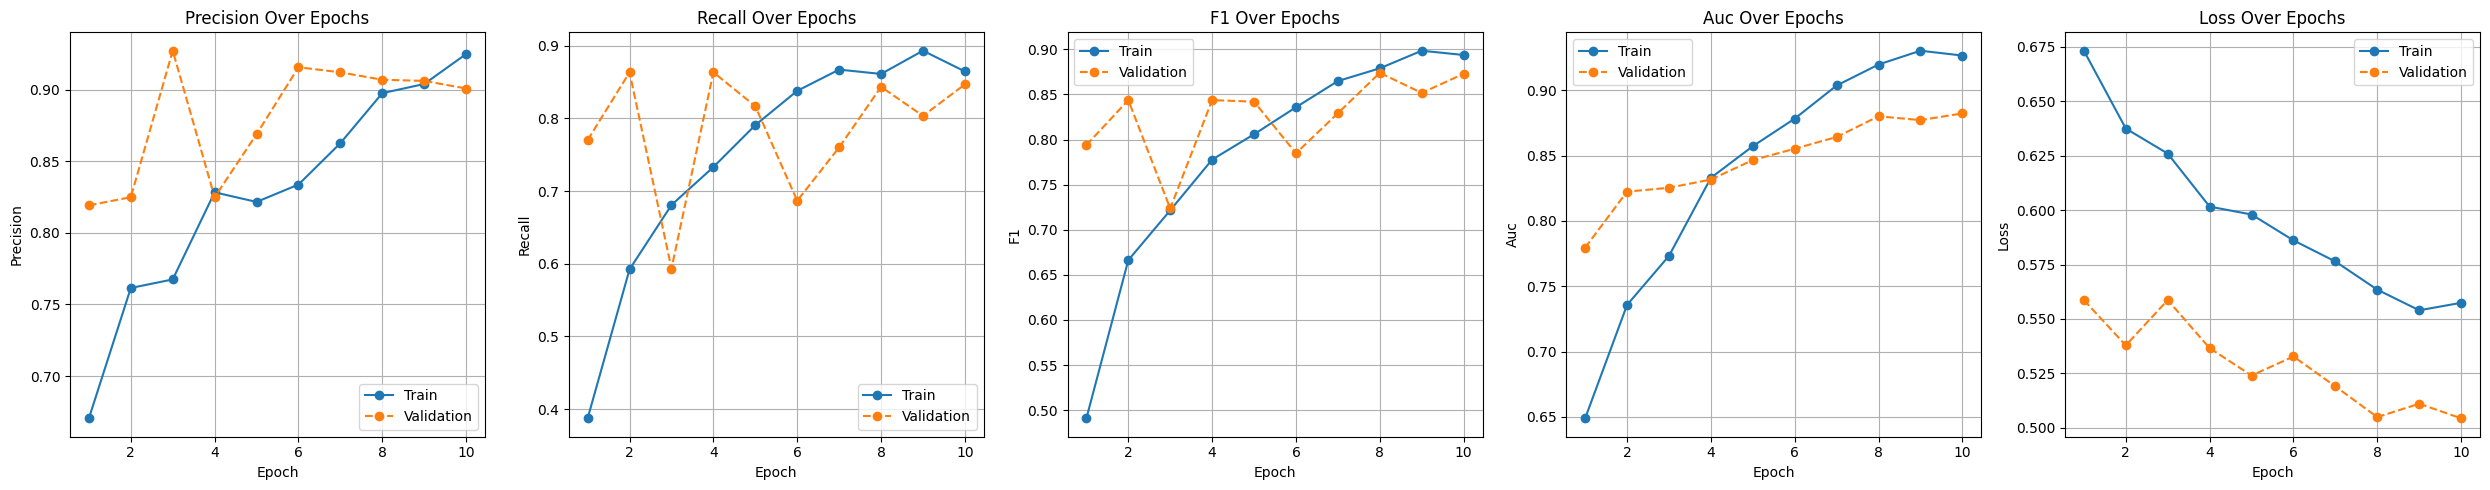

In [11]:
import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """
    Visualizes training and validation metrics over epochs.

    Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}
    metric_names = list(train_metrics.keys())
    
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]
    
    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_metrics(metrics)

In [12]:
import torch
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_curve
)
import matplotlib.pyplot as plt

class ModelEvaluator:
    def __init__(self, model, test_loader, device="cuda", class_names=None):
        """
        Initialize the evaluator with the model and test data loader.
        Args:
            model (torch.nn.Module): The trained model to evaluate.
            test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
            device (str): The device to use for evaluation (default: "cuda").
            class_names (list): List of class names for the confusion matrix.
        """
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names or ["Class 0", "Class 1"]
        self.predictions = []
        self.targets = []
        self.samples = []
        self.threshold = 0.59

    def evaluate(self):
        """Evaluate the model on the test dataset."""
        self.model.eval()
        with torch.no_grad():
            for videos, labels in self.test_loader:
                videos, labels = videos.to(self.device), labels.to(self.device)
                outputs = self.model(videos)
                probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
                self.predictions.extend(probs)
                self.targets.extend(labels.cpu().numpy())
                self.samples.extend(videos.cpu().numpy())
        
        self.predictions = np.array(self.predictions).squeeze()
        self.targets = np.array(self.targets).squeeze()
        self.samples = np.array(self.samples)
        return self._calculate_metrics()

    def _calculate_metrics(self):
        """Calculates precision, recall, F1, AUC, and accuracy."""
        binary_preds = (self.predictions > self.threshold).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            self.targets, binary_preds, average="binary"
        )
        auc = roc_auc_score(self.targets, self.predictions)
        acc = accuracy_score(self.targets, binary_preds)

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "accuracy": acc,
        }

    def plot_confusion_matrix(self):
        """Plots the confusion matrix."""
        binary_preds = (self.predictions > self.threshold).astype(int)
        cm = confusion_matrix(self.targets, binary_preds, labels=range(len(self.class_names)))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_roc_curve(self):
        """Plots the ROC curve and AUC."""
        fpr, tpr, _ = roc_curve(self.targets, self.predictions)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {self._calculate_metrics()["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_examples(self, num_examples=5):
        """
        Plots examples of misclassifications and correct classifications.
        Args:
            num_examples (int): Number of examples to display for each case.
        """
        binary_preds = (self.predictions > self.threshold).astype(int)
        misclassified_indices = np.where(binary_preds != self.targets)[0]
        correctly_classified_indices = np.where(binary_preds == self.targets)[0]

        def plot_samples(indices, title, num_examples):
            indices = np.random.choice(indices, size=min(len(indices), num_examples), replace=False)
            fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
            fig.suptitle(title, fontsize=16)
            if len(indices) == 1: 
                axes = [axes]
            for ax, idx in zip(axes, indices):
                sample = self.samples[idx]
                label = self.targets[idx]
                pred = binary_preds[idx]

                ax.imshow(sample[0, 0], cmap="gray")
                ax.set_title(f"True: {self.class_names[int(label)]}\nPred: {self.class_names[int(pred)]}")
                ax.axis("off")
            plt.show()

        if len(misclassified_indices) > 0:
            plot_samples(misclassified_indices, "Misclassified Examples", num_examples)
        else:
            print("No misclassified examples found.")

        if len(correctly_classified_indices) > 0:
            plot_samples(correctly_classified_indices, "Correctly Classified Examples", num_examples)
        else:
            print("No correctly classified examples found.")

    def display_metrics(self):
        """Calculate and display metrics, confusion matrix, and examples."""
        print("Evaluating Model...")
        metrics = self.evaluate()

        print("\nMetrics:")
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        print("\nPlotting Confusion Matrix...")
        self.plot_confusion_matrix()

        print("\nDisplaying Examples...")
        self.plot_examples()

        print("\nPlotting ROC Curve...")
        self.plot_roc_curve()


In [13]:
evaluator = ModelEvaluator(model,test_loader,class_names=['Real','Fake'])

Evaluating Model...

Metrics:
Precision: 0.8339
Recall: 0.8200
F1: 0.8269
Auc: 0.8027
Accuracy: 0.7627

Plotting Confusion Matrix...


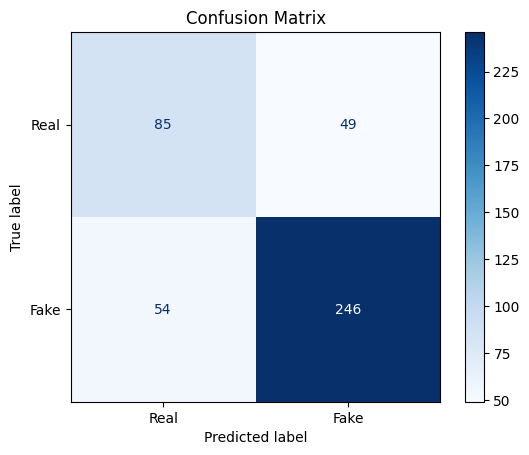


Displaying Examples...


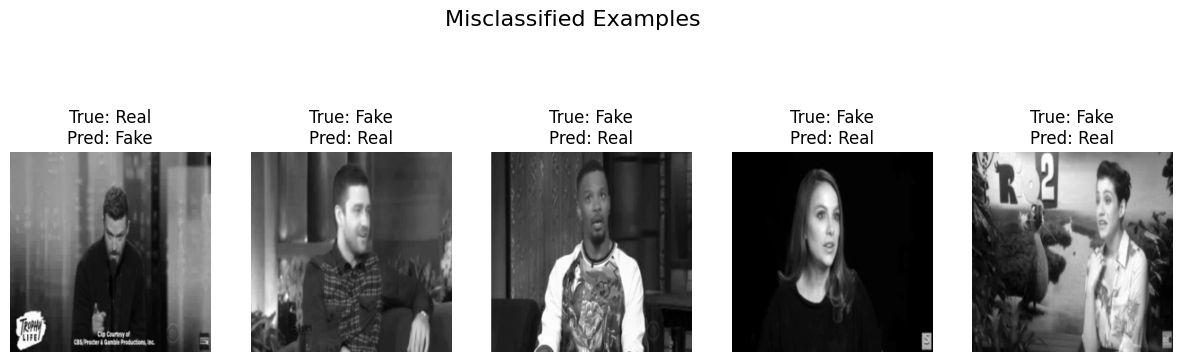

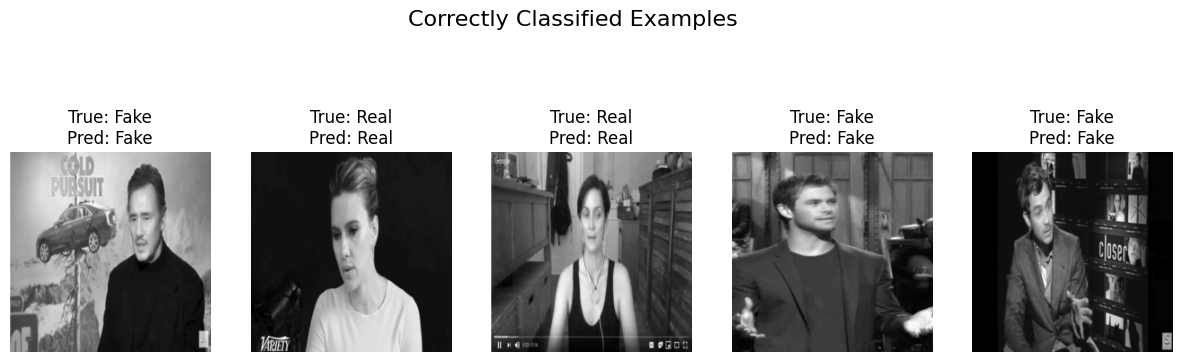


Plotting ROC Curve...


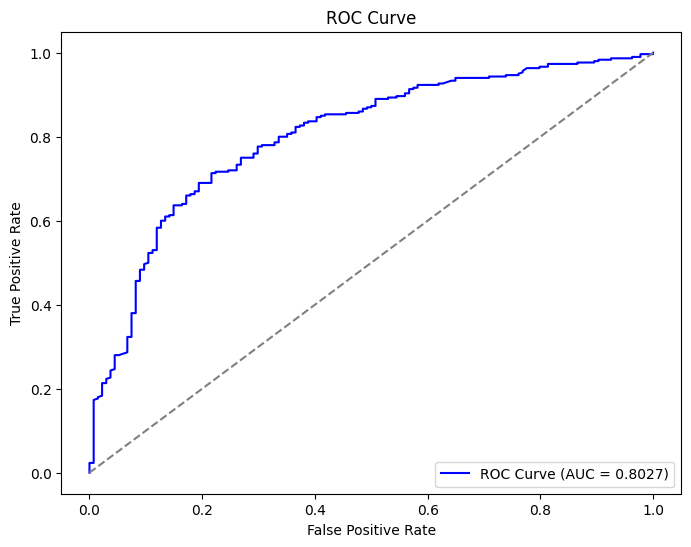

In [14]:
evaluator.display_metrics()

In [15]:
torch.save(model.state_dict(), "deepfake_model.pth")

from IPython.display import FileLink
FileLink("best_model.pth")

/kaggle/working/best_model.pth